<a href="https://colab.research.google.com/github/imaboylol/itmo-advanced-ml-and-dl/blob/main/classification-logreg/Log_Reg_Students.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Применение логистической регрессии для решения задачи классификации

# Описание набора данных

Данный набор содержит информацию о пассажирах корабля «Титаник», затонувшего в ночь на 15-е апреля 1912 года. Некоторое количество пассажиров спаслось, чему способствовало множество различных факторов, включая их пол, возраст, на какой палубе находилась их кабина, социальный статус, и т.д.

Набор данных состоит из различных признаков, описывающих информацию о пассажирах. Каждая строка таблицы — отдельный пассажир, вся информация о нем содержится в его строке.

Описание датасета:
- **Survived** (целевой признак): выжил ли пассажир (0 = Нет, 1 = Да);
- **Pclass**: класс каюты (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: пол (female или male)
- **Age**: возраст в годах
- **SibSp**: количество братьев, сестёр (в том числе сводных) и супругов на борту
- **Parch**: количество детей и родителей на борту
- **Ticket**: номер билета
- **Fare**: стоимость проезда пассажира
- **Cabin**: номер каюты
- **Embarked**: порт посадки пассажира (C = Cherbourg, Q = Queenstown, S = Southampton).

Необходимо решить задачу классификации и научиться предсказывать целовой признак **Survived** — выживет ли пассажир — по соответсвующим ему нецелевым признакам.


# Подготовка и первичный анализ данных

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [4]:
df = pd.read_csv('titanic_train.csv', header=None, delimiter=';', quotechar='"')
df = df.rename(columns={0: "features"})
df = df['features'].str.split(',',expand=True)
df['name'] = df[2] + df[3]
df = df.drop([2, 3], axis='columns')
#строка 0 не нужна - дублирует имена столбцов
df = df.drop([0], inplace=False)
df = df.rename(columns={0: "pclass", 1: "survived", 4: "sex",
                        5: "age", 6: "sibsp", 7: "parch", 8: "ticket",
                        9: "fare", 10: "cabin", 11: "embarked"})
df = df.drop([12, 13, 14, 15], axis='columns')
#номер билета не нужен
df = df.drop(["ticket"], axis='columns')
df[['pclass', 'survived', 'sibsp', 'parch']] = df[['pclass', 'survived', 'sibsp', 'parch']].astype(np.int64)
df = df.replace('', np.nan, inplace=False)
df

,pclass,survived,sex,age,sibsp,parch,fare,cabin,embarked,name
1,3,1,female,NaN,0,0,7.7333,NaN,Q,"""Smyth Miss. Julia"""
2,3,1,female,NaN,0,0,7.75,NaN,Q,"""Glynn Miss. Mary Agatha"""
3,3,1,female,38.0,0,0,7.2292,NaN,C,"""Whabee Mrs. George Joseph (Shawneene Abi-Saab)"""
4,3,0,male,22.0,0,0,7.8958,NaN,S,"""Vovk Mr. Janko"""
5,3,0,male,16.0,0,0,9.5,NaN,S,"""de Pelsmaeker Mr. Alfons"""
...,...,...,...,...,...,...,...,...,...,...
977,3,1,female,NaN,0,0,8.05,NaN,S,"""Howard Miss. May Elizabeth"""
978,3,1,male,19.0,0,0,8.05,NaN,S,"""Dorking Mr. Edward Arthur"""
979,2,0,male,34.0,0,0,13.0,NaN,S,"""Gillespie Mr. William Henry"""
980,3,0,male,22.0,0,0,8.05,NaN,S,"""Barton Mr. David John"""


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 1 to 981
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   pclass    981 non-null    int64 
 1   survived  981 non-null    int64 
 2   sex       981 non-null    object
 3   age       782 non-null    object
 4   sibsp     981 non-null    int64 
 5   parch     981 non-null    int64 
 6   fare      981 non-null    object
 7   cabin     212 non-null    object
 8   embarked  981 non-null    object
 9   name      981 non-null    object
dtypes: int64(4), object(6)
memory usage: 76.8+ KB


Установите количество пропущенных значений поля <code>age</code>:

In [6]:
df.isnull().sum()

,0
pclass,0
survived,0
sex,0
age,199
sibsp,0
parch,0
fare,0
cabin,769
embarked,0
name,0


In [7]:
df = df.drop(['cabin'], axis='columns')

Определите долю выживших

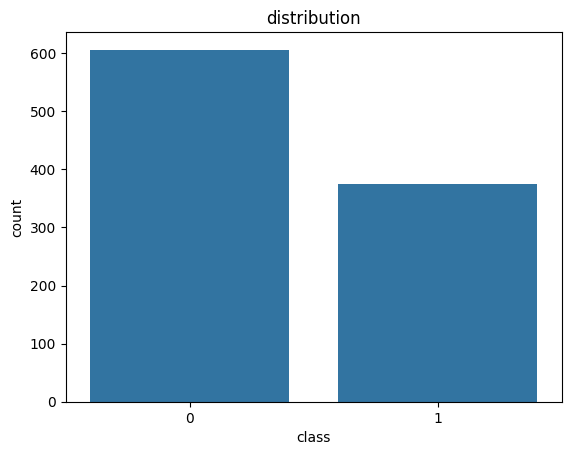

In [8]:
sns.countplot(data=df, x='survived')
plt.title('distribution')
plt.xlabel('class')
plt.ylabel('count')
plt.show()

In [9]:
class_counts = df['survived'].value_counts()
frac_surv = 375 / 981
print(class_counts)
print("fraction of survived =", frac_surv)

survived
0    606
1    375
Name: count, dtype: int64
fraction of survived = 0.382262996941896


Из описания набора данных видно, что колонки <code>sibsp</code> и <code>parch</code> по сути отвечают за размер семьи. Замените эти две колонки на колонку <code>fam_size</code>, значения которой будут вычисляться как сумма соответствующих значений в колонках <code>sibsp</code> и <code>parch</code>.

In [10]:
df['fam_size'] = df[['sibsp', 'parch']].sum(axis=1)
df = df.drop(['sibsp','parch'], axis='columns')
df

,pclass,survived,sex,age,fare,embarked,name,fam_size
1,3,1,female,NaN,7.7333,Q,"""Smyth Miss. Julia""",0
2,3,1,female,NaN,7.75,Q,"""Glynn Miss. Mary Agatha""",0
3,3,1,female,38.0,7.2292,C,"""Whabee Mrs. George Joseph (Shawneene Abi-Saab)""",0
4,3,0,male,22.0,7.8958,S,"""Vovk Mr. Janko""",0
5,3,0,male,16.0,9.5,S,"""de Pelsmaeker Mr. Alfons""",0
...,...,...,...,...,...,...,...,...
977,3,1,female,NaN,8.05,S,"""Howard Miss. May Elizabeth""",0
978,3,1,male,19.0,8.05,S,"""Dorking Mr. Edward Arthur""",0
979,2,0,male,34.0,13.0,S,"""Gillespie Mr. William Henry""",0
980,3,0,male,22.0,8.05,S,"""Barton Mr. David John""",0


In [11]:
mean_fam_size = df['fam_size'].mean()
print("mean fam_size: ", mean_fam_size)

mean fam_size:  0.8664627930682977


Полученный датасет будем называть **исходным** (выброшенные на этом этапе признаки не нужно возвращать ни на одном из последующих этапов выполнения задания). Вычислите полученное число предикторов.

In [12]:
# < ENTER YOUR CODE HERE >
# очевидно, число предикторов = 8 - df['survived'] = 7

На основе имеющейся статистики оцените вероятность выжить если пассажир -- представитель определенной категории (указана в вашем индивидуальном задании)

In [13]:
# < ENTER YOUR CODE HERE >
filtered_df = df[(df['pclass'] == 3) & (df['sex'] == 'male')]
filtered_df
filtered_counts = filtered_df['survived'].value_counts()
filtered_counts

,count
survived,
0,310
1,61


In [14]:
prob_if_survived = 61 / (371)
print(prob_if_survived)

0.16442048517520216


# Модель на основе числовых признаков

## Удаление строк с пропусками

В качестве базовой модели имеет смысл построить модель с минимальными трудозатратами.

Из исходного датасета удалите все категориальные признаки, а также строки, содержащие пропуски.

При помощи <code>train_test_split()</code> разбейте набор данных на обучающую и тестовую выборки<b> с параметрами, указанными в вашем задании</b>. Используйте стратификацию по колонке <code>survived</code>.

Обучите модель <code>LogisticRegression()</code> <b>с параметрами, указанными в вашем задании</b>, на тренировочных данных, оцените на тестовых.

Вычислите <code>f1_score</code> модели на тестовых данных (рекомендуем использовать <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">соответствующую функцию</a> с параметрами по умолчанию.



In [15]:
# < ENTER YOUR CODE HERE >
df_pre_train = df.drop(['sex','embarked','name'], axis='columns')
df_pre_train = df_pre_train.dropna(subset=['age'])
X = df_pre_train.drop(columns=['survived'])
y = df_pre_train['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=df_pre_train['survived'])

In [16]:
lr = LogisticRegression(random_state=23, max_iter=1000).fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [17]:
f1 = f1_score(y_test, y_pred)
print("F1-score: ", f1)

F1-score:  0.48


## Заполнение пропусков средним

Качество полученной модели оставляет желать лучшего. Имеет смысл попробовать заполнить пропуски. Из исходного набора данных удалите категориальные признаки, а пропуски заполните средним по столбцу. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [18]:
# < ENTER YOUR CODE HERE >
df_mean = df.drop(['sex','embarked','name'], axis='columns')
df_mean[['age','fare']] = df_mean[['age','fare']].astype(np.float64)
df_mean.fillna(df_mean.mean(), inplace=True)
#df_mean.info()
X = df_mean.drop(columns=['survived'])
y = df_mean['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=df_mean['survived'])

In [19]:
lr_mean = LogisticRegression(random_state=23, max_iter=1000).fit(X_train, y_train)
y_pred = lr_mean.predict(X_test)

In [20]:
f1 = f1_score(y_test, y_pred)
print("F1-score mean model: ", f1)

F1-score mean model:  0.4881889763779528


## Заполнение пропусков на основе обращения


Очевидно, что заполнение пропусков в колонке <code>age</code> средним — не самая разумная идея. Возможно, стоит выполнить эту процедуру как-то более интеллектуально, например, с оглядкой на обращение к человеку.

Можно заметить, что исходный датасет в столбце <code>name</code> содержит информацию о социальном статусе пассажира, а именно присутсвуют обращения <code>Mr., Mrs., Dr.</code> и т.д. На основе этой информации можно попробовать сделать предположение о возрасте пассажира.

Верните в рассмотрение колонку <code>name</code>. Создайте отдельную колонку <code>honorific</code> и поместите туда значения обращений.

Скорее всего имеет смысл сократить число обращений, добавив малочисленные группы к более многочисленным, так как принципиальной разницы между, например, <code>Don</code> и <code>Mr</code>, видимо, нет. Отметим, что <code>Master</code> — это прежнее обращение к ребенку, с этим обращением будем работать отдельно.




Выполните следующие замены:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [21]:
# Создаем словарь для объединений обращений
honorific_map = {
    'Mr.': ['Rev.', 'Col.', 'Dr.', 'Major.', 'Don.', 'Capt.'],
    'Mrs.': ['Dona', 'Countess'],
    'Miss.': ['Mlle.', 'Ms.']
}

# Функция для извлечения и объединения обращений
def extract_honorific(name):
    for main_honorific, variants in honorific_map.items():
        for variant in variants:
            if variant in name:
                return main_honorific
    # Если не было совпадений, возвращаем исходное обращение
    if 'Mr.' in name:
        return 'Mr.'
    elif 'Mrs.' in name:
        return 'Mrs.'
    elif 'Miss.' in name:
        return 'Miss.'
    else:
        return None

# Объединяем обращения
df['honorific'] = df['name'].apply(extract_honorific)
# Master. соответствует ребёнку мужского пола - эту категорию оставляем отдельно
df['honorific'] = df['honorific'].replace(np.nan, 'Master.', inplace=False)
df['honorific'].value_counts()

,count
honorific,
Mr.,590
Miss.,198
Mrs.,147
Master.,46


Вычислите долю строк со значением <code>Master</code> относительно числа всех мужчин

In [22]:
# < ENTER YOUR CODE HERE >
# Master = 46
# 46 / 636 = 0.072
sex_counts = df['sex'].value_counts()
sex_counts

,count
sex,
male,636
female,345


Вычислите средний возраст категории, указанной в вашем индивидуальном задании

Mean age Mr.

In [23]:
filtered_df_mr = df[(df['honorific'] == 'Mr.')]
filtered_df_mr[['age']] = filtered_df_mr[['age']].astype(np.float64)
mean_mr_age = filtered_df_mr['age'].mean()
print("mean Mr. age: ", mean_mr_age)

mean Mr. age:  32.90043763676149


<ipython-input-23-ad5930c523b3>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_mr[['age']] = filtered_df_mr[['age']].astype(np.float64)


Mean age Mrs.

In [24]:
filtered_df_mrs = df[(df['honorific'] == 'Mrs.')]
filtered_df_mrs[['age']] = filtered_df_mrs[['age']].astype(np.float64)
mean_mrs_age = filtered_df_mrs['age'].mean()
print("mean Mrs. age: ", mean_mrs_age)

mean Mrs. age:  36.98425196850393


<ipython-input-24-a8d728eff039>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_mrs[['age']] = filtered_df_mrs[['age']].astype(np.float64)


Mean age Miss.

In [25]:
filtered_df_miss = df[(df['honorific'] == 'Miss.')]
filtered_df_miss[['age']] = filtered_df_miss[['age']].astype(np.float64)
mean_miss_age = filtered_df_miss['age'].mean()
print("mean Miss. age: ", mean_miss_age)

mean Miss. age:  22.00576540880503


<ipython-input-25-0ce25712a7b8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_miss[['age']] = filtered_df_miss[['age']].astype(np.float64)


Mean age Master.

In [26]:
filtered_df_master = df[(df['honorific'] == 'Master.')]
filtered_df_master[['age']] = filtered_df_master[['age']].astype(np.float64)
mean_master_age = filtered_df_master['age'].mean()
print("mean Master. age: ", mean_master_age)

mean Master. age:  5.128205128205129


<ipython-input-26-5e2ea02c58e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df_master[['age']] = filtered_df_master[['age']].astype(np.float64)


Заполните пропуски в колонке <code>age</code> средним, соответствующим среднему категории <code>honorific</code>.

Избавьтесь от нечисловых признаков. Далее аналогично: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [27]:
df[['age', 'fare']] = df[['age','fare']].astype(np.float64)
df['age'] = df['age'].fillna(df.groupby('honorific')['age'].transform('mean'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981 entries, 1 to 981
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     981 non-null    int64  
 1   survived   981 non-null    int64  
 2   sex        981 non-null    object 
 3   age        981 non-null    float64
 4   fare       981 non-null    float64
 5   embarked   981 non-null    object 
 6   name       981 non-null    object 
 7   fam_size   981 non-null    int64  
 8   honorific  981 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 69.1+ KB


In [28]:
df_mean = df.drop(['sex','embarked','name', 'honorific'], axis='columns')
X = df_mean.drop(columns=['survived'])
y = df_mean['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=df_mean['survived'])

In [29]:
lr_mean_age = LogisticRegression(random_state=23, max_iter=1000).fit(X_train, y_train)
y_pred = lr_mean_age.predict(X_test)

f1 = f1_score(y_test, y_pred)
print("F1-score mean age model: ", f1)

F1-score mean age model:  0.484375


In [30]:
df

,pclass,survived,sex,age,fare,embarked,name,fam_size,honorific
1,3,1,female,22.005765,7.7333,Q,"""Smyth Miss. Julia""",0,Miss.
2,3,1,female,22.005765,7.7500,Q,"""Glynn Miss. Mary Agatha""",0,Miss.
3,3,1,female,38.000000,7.2292,C,"""Whabee Mrs. George Joseph (Shawneene Abi-Saab)""",0,Mrs.
4,3,0,male,22.000000,7.8958,S,"""Vovk Mr. Janko""",0,Mr.
5,3,0,male,16.000000,9.5000,S,"""de Pelsmaeker Mr. Alfons""",0,Mr.
...,...,...,...,...,...,...,...,...,...
977,3,1,female,22.005765,8.0500,S,"""Howard Miss. May Elizabeth""",0,Miss.
978,3,1,male,19.000000,8.0500,S,"""Dorking Mr. Edward Arthur""",0,Mr.
979,2,0,male,34.000000,13.0000,S,"""Gillespie Mr. William Henry""",0,Mr.
980,3,0,male,22.000000,8.0500,S,"""Barton Mr. David John""",0,Mr.


# Модель с использование категориальных признаков

В исходном наборе данных заполните пропуски колонки <code>age</code> значениями на основе обращений (как в предыдущем пункте).

Не используйте признаки <code>name</code> и <code>honorific</code>. Они свою функцию выполнили.

Произведите <code>one-hot</code> кодировние нечисловых признаков, например, с помощью <code>pd.get_dummies(drop_first=True)</code>. Далее по знакомой схеме: разделение, обучение, оценка.

Вычислите <code>f1_score</code> модели на тестовых данных

In [31]:
# < ENTER YOUR CODE HERE >
df_cat = df.drop(['name', 'honorific'], axis='columns')
df_cat = pd.get_dummies(df_cat, drop_first=True)
df_cat

,pclass,survived,age,fare,fam_size,sex_male,embarked_Q,embarked_S
1,3,1,22.005765,7.7333,0,False,True,False
2,3,1,22.005765,7.7500,0,False,True,False
3,3,1,38.000000,7.2292,0,False,False,False
4,3,0,22.000000,7.8958,0,True,False,True
5,3,0,16.000000,9.5000,0,True,False,True
...,...,...,...,...,...,...,...,...
977,3,1,22.005765,8.0500,0,False,False,True
978,3,1,19.000000,8.0500,0,True,False,True
979,2,0,34.000000,13.0000,0,True,False,True
980,3,0,22.000000,8.0500,0,True,False,True


In [32]:
X = df_cat.drop(columns=['survived'])
y = df_cat['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23, stratify=df_mean['survived'])

In [33]:
lr_cat = LogisticRegression(random_state=23, max_iter=1000).fit(X_train, y_train)
y_pred = lr_cat.predict(X_test)

f1 = f1_score(y_test, y_pred)
print("F1-score model with cats: ", f1)

F1-score model with cats:  0.6814814814814815


# Предсказание зарезервированной части датасета

Train set

In [68]:
df_cat

,pclass,survived,age,fare,fam_size,sex_male,embarked_Q,embarked_S
1,3,1,22.005765,7.7333,0,False,True,False
2,3,1,22.005765,7.7500,0,False,True,False
3,3,1,38.000000,7.2292,0,False,False,False
4,3,0,22.000000,7.8958,0,True,False,True
5,3,0,16.000000,9.5000,0,True,False,True
...,...,...,...,...,...,...,...,...
977,3,1,22.005765,8.0500,0,False,False,True
978,3,1,19.000000,8.0500,0,True,False,True
979,2,0,34.000000,13.0000,0,True,False,True
980,3,0,22.000000,8.0500,0,True,False,True


In [70]:
df_test = pd.read_csv('titanic_reserved.csv', header=None, delimiter=';', quotechar='"')
df_test = df_test.rename(columns={0: "features"})
df_test = df_test['features'].str.split(',',expand=True)
df_test['name'] = df_test[1] + df_test[2]
df_test = df_test.drop([1, 2], axis='columns')
#строка 0 не нужна - дублирует имена столбцов
df_test = df_test.drop([0], inplace=False)
df_test = df_test.rename(columns={0: "pclass", 3: "sex", 4: "age",
                        5: "sibsp", 6: "parch", 7: "ticket", 8: "fare",
                        9: "cabin", 10: "embarked"})
df_test = df_test.drop([11, 12, 13, 14], axis='columns')
#номер билета не нужен
df_test = df_test.drop(["ticket"], axis='columns')
df_test[['pclass', 'sibsp', 'parch']] = df_test[['pclass', 'sibsp', 'parch']].astype(np.int64)
df_test = df_test.replace('', np.nan, inplace=False)

In [71]:
df_test['fam_size'] = df_test[['sibsp', 'parch']].sum(axis=1)
df_test = df_test.drop(['sibsp','parch'], axis='columns')

In [72]:
df_test = df_test.drop(['cabin'], axis='columns')

In [73]:
# Объединяем обращения
df_test['honorific'] = df_test['name'].apply(extract_honorific)
# Master. соответствует ребёнку мужского пола - эту категорию оставляем отдельно
df_test['honorific'] = df_test['honorific'].replace(np.nan, 'Master.', inplace=False)
df_test['honorific'].value_counts()

,count
honorific,
Mr.,190
Miss.,66
Mrs.,53
Master.,19


In [74]:
df_test[['age', 'fare']] = df_test[['age', 'fare']].astype(np.float64)
df_test['age'] = df_test['age'].fillna(df_test.groupby('honorific')['age'].transform('mean'))
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328 entries, 1 to 328
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     328 non-null    int64  
 1   sex        328 non-null    object 
 2   age        328 non-null    float64
 3   fare       328 non-null    float64
 4   embarked   326 non-null    object 
 5   name       328 non-null    object 
 6   fam_size   328 non-null    int64  
 7   honorific  328 non-null    object 
dtypes: float64(2), int64(2), object(4)
memory usage: 20.6+ KB


In [75]:
df_test = df_test.drop(['name', 'honorific'], axis='columns')
df_test = pd.get_dummies(df_test, drop_first=True)
df_test

,pclass,age,fare,fam_size,sex_male,embarked_Q,embarked_S
1,3,32.267123,69.5500,10,True,False,True
2,1,24.000000,82.2667,1,True,False,True
3,2,57.000000,13.0000,0,True,False,True
4,3,18.000000,20.2125,2,True,False,True
5,2,18.000000,23.0000,1,False,False,True
...,...,...,...,...,...,...,...
324,1,32.267123,39.6000,0,True,False,False
325,1,45.000000,26.5500,0,True,False,True
326,1,37.260870,82.1708,1,False,False,False
327,2,0.833300,29.0000,2,True,False,True


Теперь весь df_cat используем как обучающую выборку, а df_test - как тестовую

In [76]:
X_train = df_cat.drop(columns=['survived'])
y_train = df_cat['survived']

X_reserved = df_test #X_test

In [80]:
lr = LogisticRegression(random_state=23, max_iter=1000).fit(X_train, y_train)
y_pred_reserved = lr.predict(X_reserved)

In [84]:
result_prediction_list = y_pred_reserved.tolist()
print(result_prediction_list)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0]
